## Breast cancer prediagnosis ver. 1.0
![alt text](https://lh5.googleusercontent.com/tQSIQYMMyNy4X-EsYF6WH2aA90otBV8VlBBairvc5XQegHh7lZ6JxESjD7WBWt71mGGMAYLlyLNPymN0UlyP-nlz1quGd59GO9_aaUtSQWNbh_yg8_3CNSERdO3S8dKFBggco_yN)

Based on: [Fuzzy method for pre-diagnosis of breast cancer from the Fine Needle Aspirate analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3772701/?fbclid=IwAR1al0TQdSuaN-L1Kg90JEWiRpEM4WVaUfCwGT9tUcMzqLABkaZxprNmfeU)

# **Load data**

**Download data**

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

In [ ]:
import pandas as pd

column_names = [ "id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean","symmetry_mean",
                "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se",
                "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst",
                "symmetry_worst", "fractal_dimension_worst" ]
                
data = pd.read_csv("wdbc.data", names=column_names, header=None, index_col=[0])

**Count uniformity and homogenity**

In [ ]:
data['uniformity'] = data.apply(lambda row: row.radius_worst - row.radius_mean, axis=1)
data['homogenity'] = data.apply(lambda row: row.symmetry_worst - row.symmetry_mean, axis=1)

In [ ]:
data.sample(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,uniformity,homogenity
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
894604,B,10.25,16.18,66.52,324.2,0.10610,0.11110,0.067260,0.039650,0.1743,0.07279,0.3677,1.4710,1.597,22.68,0.010490,0.042650,0.040040,0.015440,0.02719,0.007596,11.28,20.61,71.53,390.4,0.14020,0.23600,0.18980,0.09744,0.2608,0.09702,1.03,0.0865
909445,M,17.27,25.42,112.40,928.8,0.08331,0.11090,0.120400,0.057360,0.1467,0.05407,0.5100,1.6790,3.283,58.38,0.008109,0.043080,0.049420,0.017420,0.01594,0.003739,20.38,35.46,132.80,1284.0,0.14360,0.41220,0.50360,0.17390,0.2500,0.07944,3.11,0.1033
88203002,B,11.22,33.81,70.79,386.8,0.07780,0.03574,0.004967,0.006434,0.1845,0.05828,0.2239,1.6470,1.489,15.46,0.004359,0.006813,0.003223,0.003419,0.01916,0.002534,12.36,41.78,78.44,470.9,0.09994,0.06885,0.02318,0.03002,0.2911,0.07307,1.14,0.1066
873885,M,15.28,22.41,98.92,710.6,0.09057,0.10520,0.053750,0.032630,0.1727,0.06317,0.2054,0.4956,1.344,19.53,0.003290,0.013950,0.017740,0.006009,0.01172,0.002575,17.80,28.03,113.80,973.1,0.13010,0.32990,0.36300,0.12260,0.3175,0.09772,2.52,0.1448
877989,M,17.54,19.32,115.10,951.6,0.08968,0.11980,0.103600,0.074880,0.1506,0.05491,0.3971,0.8282,3.088,40.73,0.006090,0.025690,0.027130,0.013450,0.01594,0.002658,20.42,25.84,139.50,1239.0,0.13810,0.34200,0.35080,0.19390,0.2928,0.07867,2.88,0.1422


In [ ]:
data_clean = data[["diagnosis", "area_mean", "perimeter_mean", "uniformity", "homogenity"]]

In [ ]:
data_clean.sample(5)

,diagnosis,area_mean,perimeter_mean,uniformity,homogenity
id,,,,,
9011495,B,458.4,78.31,2.080,0.1523
8810436,B,725.5,98.17,2.110,0.0961
88299702,M,1670.0,153.50,7.800,0.1194
923780,B,378.4,71.49,0.890,0.1139
915186,B,248.7,61.49,1.012,0.0660


# **Create FCL**

**Prepare FCL Libraries**

In [ ]:
!pip install scikit-fuzzy 
!pip install ply #For parser

In [ ]:
#FCL Parser to scikit-fuzzy
!git clone https://github.com/jfpower/fcl-for-scikit-fuzzy
!mv fcl-for-scikit-fuzzy/ fcl/

In [ ]:
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import sys
import numpy as np
sys.path.insert(1, '/content/fcl')

In [ ]:
from fcl_parser import FCLParser

**Prepare FCL File**

In [ ]:
%%shell
cat << EOT > sterownik.fcl
FUNCTION_BLOCK prognose

VAR_INPUT
	area: REAL;
	perimeter: REAL;
  uniformity: REAL;
  homogenity: REAL;
END_VAR

VAR_OUTPUT
  diagnosis: REAL;
END_VAR

FUZZIFY area
	TERM small := (185, 1) (748, 1) (1000,0);
	TERM large := (508, 0) (2194, 1)
  RANGE := (185 .. 4255);
END_FUZZIFY

FUZZIFY perimeter
	TERM small := (50.0, 1) (92.5, 1) (103,0);
	TERM large := (85, 0) (159, 1)
  RANGE := (50.0 .. 252.0);
END_FUZZIFY

FUZZIFY uniformity
	TERM more := (0.0, 1) (1.66, 1) (2.6,0);
	TERM less := (0.65, 0) (6.2, 1)
  RANGE := (0.0 .. 12.0);
END_FUZZIFY

FUZZIFY homogenity
	TERM more := (0.0, 1) (0.12, 1) (0.19,0);
	TERM less := (0.03, 0) (0.215, 1)
  RANGE := (0.0 .. 0.45);
END_FUZZIFY

DEFUZZIFY diagnosis
	TERM benign := (0.0, 1) (0.4, 1) (0.5, 0)
	TERM undefined := (0.5, 0) (0.55, 1) (0.6, 0)
	TERM malignant := (0.6, 0) (0.7, 1)
	METHOD : COG;
	DEFAULT := 0.55;		
  RANGE := (0.0 .. 1.0);
END_DEFUZZIFY

RULEBLOCK No1
	AND : MIN;
	ACT : MIN;
	ACCU : MAX;

	RULE 1 : IF area IS small and perimeter is small and uniformity is more and homogenity is more THEN diagnosis is benign

  RULE 2 : IF area IS small and perimeter is small and uniformity is more and homogenity is less THEN diagnosis is undefined
  RULE 3 : IF area IS small and perimeter is small and uniformity is less and homogenity is more THEN diagnosis is undefined
  RULE 4 : IF area IS small and perimeter is small and uniformity is less and homogenity is less THEN diagnosis is undefined
  RULE 5 : IF area IS small and perimeter is large and uniformity is more and homogenity is more THEN diagnosis is undefined
  RULE 6 : IF area IS small and perimeter is large and uniformity is more and homogenity is less THEN diagnosis is undefined
  RULE 7 : IF area IS small and perimeter is large and uniformity is less and homogenity is more THEN diagnosis is undefined
  RULE 8 : IF area IS small and perimeter is large and uniformity is less and homogenity is less THEN diagnosis is undefined
  RULE 9 : IF area IS large and perimeter is small and uniformity is more and homogenity is more THEN diagnosis is undefined
  RULE 10 : IF area IS large and perimeter is small and uniformity is more and homogenity is less THEN diagnosis is undefined
  RULE 11 : IF area IS large and perimeter is small and uniformity is less and homogenity is more THEN diagnosis is undefined
  RULE 12 : IF area IS large and perimeter is small and uniformity is less and homogenity is less THEN diagnosis is undefined
  RULE 13 : IF area IS large and perimeter is large and uniformity is more and homogenity is more THEN diagnosis is undefined
  RULE 14 : IF area IS large and perimeter is large and uniformity is more and homogenity is less THEN diagnosis is undefined
  RULE 15 : IF area IS large and perimeter is large and uniformity is less and homogenity is more THEN diagnosis is undefined

	RULE 16 : IF area IS large and perimeter is large and uniformity is less and homogenity is less THEN diagnosis is malignant 
END_RULEBLOCK

END_FUNCTION_BLOCK
EOT

In [ ]:
#Furia vec
p = FCLParser()
p.read_fcl_file('sterownik.fcl')
cs = ctrl.ControlSystem(p.rules)
system = ctrl.ControlSystemSimulation(cs)

# **Simulate**

**Basic tests**

In [ ]:
#TEST 1 BENIGN
system.input['area'] = 400
system.input['perimeter'] = 80
system.input['uniformity'] = 0.5
system.input['homogenity'] = 0.02
system.compute()
print(system.output['diagnosis'])

#TEST 2 MALIGNANT
system.input['area'] = 3000
system.input['perimeter'] = 220
system.input['uniformity'] = 10
system.input['homogenity'] = 0.38
system.compute()
print(system.output['diagnosis'])

#TEST 3 UNDEFINED
system.input['area'] = 400
system.input['perimeter'] = 220
system.input['uniformity'] = 0.5
system.input['homogenity'] = 0.38
system.compute()
print(system.output['diagnosis'])

0.22592592592592603
0.8233061127029606
0.5499999999999998


**Tests on data**

In [ ]:
def give_label(predict_value):
  if predict_value >= 0.7:
    return "M"
  elif predict_value <= 0.4:
    return "B"
  return "Undef"

In [ ]:
#Save predictions
output_values = []
output_labels = []

#Accuracy variables
accuracy_sum = 0
all_predicted = 0

#Recall / precision / true negative rate
TP = 0
TN = 0
FN = 0
FP = 0

for index, row in data_clean.iterrows():
  system.input['area'] = row['area_mean']
  system.input['perimeter'] = row['perimeter_mean']
  system.input['uniformity'] = row['uniformity']
  system.input['homogenity'] = row['homogenity']
  system.compute()

  out_val = system.output['diagnosis']
  label = give_label(out_val)

  output_values.append(out_val)
  output_labels.append(label)

  #Get accuracy
  if label != "Undef":
    all_predicted += 1
    if label == row['diagnosis']: #Predicted good
      accuracy_sum += 1
      if label == 'M': #Predicted Malignant good
        TP += 1
      if label == 'B':  #Predicted Benign good
        TN += 1
    else: #Predicted bad
      if label == 'M': #Predicted Malignant bad
        FN += 1
      if label == 'B': #Predicted Benign bad
        FP += 1

In [ ]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
f2 = 5 * (precision * recall) / (4 * precision + recall)
print("Dataset size: %d" % len(data_clean.index))
print("Predicted proportions: %f" % (all_predicted / len(data_clean.index)))
print("Undefined count: %d" % (len(data_clean.index) - all_predicted))
print("---------------------------")
print("Accuracy: %f" % (accuracy_sum / all_predicted))
print("Recall: %f" %  (recall)) # Osobie z nowotworem złośliwym powiedzielismy ze jest łagodny !!!!!!!!!!
print("Precision: %f" %  (precision)) # Osobie z nowotorem łagodnym powiedzielismy ze jest złośliwy
print("Specificity: %f" %  (specificity))
print("---------------------------")
print("F1.0: %f" % (f1))
print("F2.0: %f" % (f2)) #Recall wazniejszy

Dataset size: 569
Predicted proportions: 0.887522
Undefined count: 64
---------------------------
Accuracy: 0.952475
Recall: 0.972603
Precision: 0.876543
Specificity: 0.944290
---------------------------
F1.0: 0.922078
F2.0: 0.951743


# **Diagrams**

**Draw inputs**

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

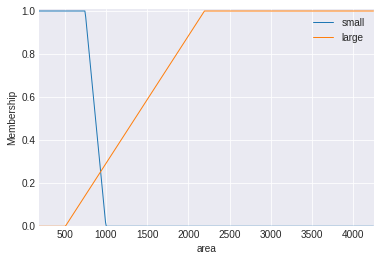

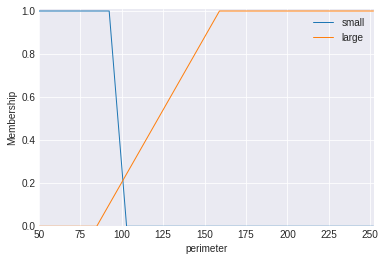

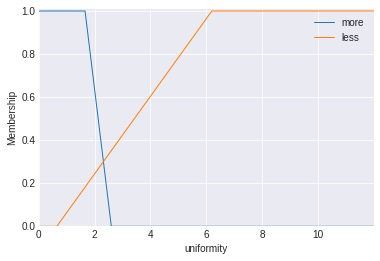

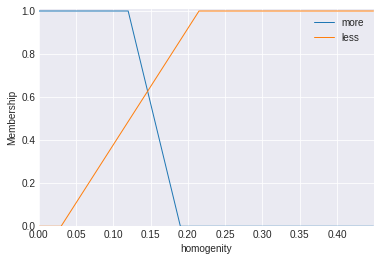

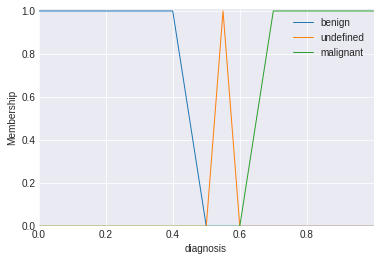

In [ ]:
p.get_var_defn("area").view()
p.get_var_defn("perimeter").view()
p.get_var_defn("uniformity").view()
p.get_var_defn("homogenity").view()
p.get_var_defn("diagnosis").view()